# Trabajo de regresión lineal multiple
#### Autor: Diaz Matias Hernan

Objetivo: Analizar los datos del dataset walmart.csv.

In [78]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from sklearn import preprocessing

### Exploración de los datos.

In [79]:
#A modo de simplificacion se crea una variable ruta con el path del archivo
ruta = 'dataset/walmart.csv'

In [80]:
df = pd.read_csv(ruta)
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


#### Datos de columnas y elección.

__8 columnas:__ Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Pice, CPI, Unemployment


__Store:__ Identificador de tienda.

__Date:__ Día que se recopilaron los datos (Cada 7 días)

__Weekly_Sales:__ Ventas semanales.

__Holiday_Flag:__ Si hubo o no feriados esa semana.

__Temperature:__ La temperatura promedio de la semana.

__Fuel_Pice:__ Precio del combustible.

__CPI:__ Índices de precios al consumidor.

__Unemployment:__ Indice de desempleo.

Se modelara un sistema para predecir el __Unemployment__ en función de __Weekly_Sales__, el __CPI__ y __Fuel_Price__.



In [81]:
#Tamaño del dataset
df.shape

(6435, 8)

In [82]:
#Primer acercamiento al dataset
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [83]:
#Inspecionamos datos faltantes
df.isnull().any()

Store           False
Date            False
Weekly_Sales    False
Holiday_Flag    False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool

### Matriz de correlación entre columnas

C:\Users\diazm\AppData\Local\Temp\ipykernel_17324\2196810584.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

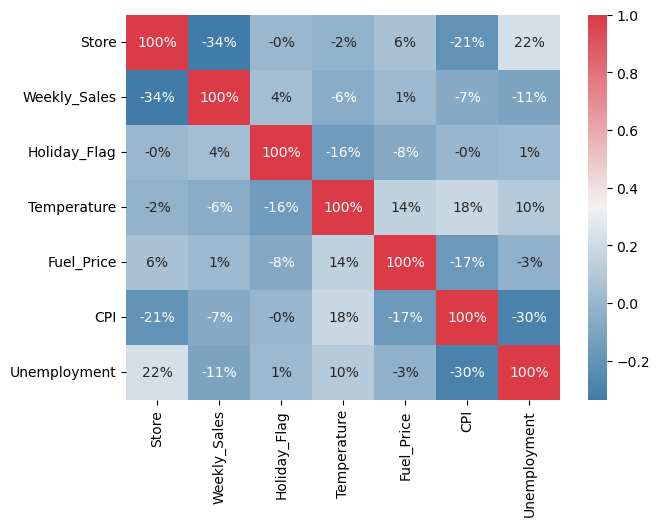

In [84]:
corr = df.corr()
plt.subplots(figsize=(7,5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.0%',
            cmap=sns.diverging_palette(240, 10, as_cmap=True)) 

In [85]:
#Se busca con precisión la correlación con Unemployment
corr['Unemployment'].abs().sort_values(ascending=False)

Unemployment    1.000000
CPI             0.302020
Store           0.223531
Weekly_Sales    0.106176
Temperature     0.101158
Fuel_Price      0.034684
Holiday_Flag    0.010960
Name: Unemployment, dtype: float64

__Nota:__ Si bien una correlacion menor a 0.10 se la puede considerar debil o inexistente puede tener trascendencia cuando la muestra es muy grande. Es por eso que el Fuel_Price fue considerado igual al momento de analizar.

### Distribución de valores

Se representan los datos en un histograma para ver la distribución de los datos

In [86]:
def histograma(df,columna):
    #Recibe un DataFrame y una columna a graficar
    plt.figure(figsize=(5,5))
    plt.title("Histograma de " + columna)
    sns.histplot(data = df[columna], kde = True, color = "red", alpha = 0.5)
    plt.show()

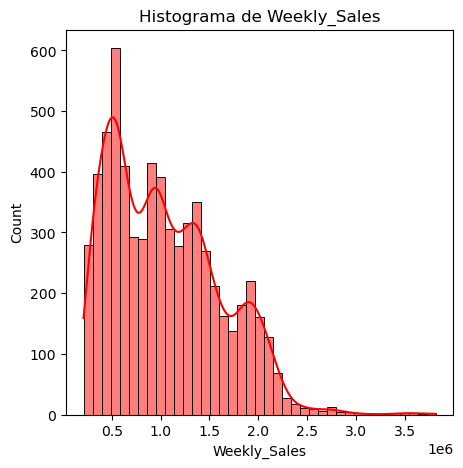

In [87]:
histograma(df,'Weekly_Sales')


__CPI__

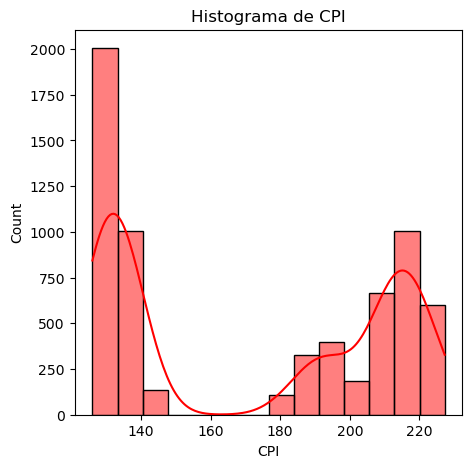

In [88]:
histograma(df,'CPI')

__Unemployment__

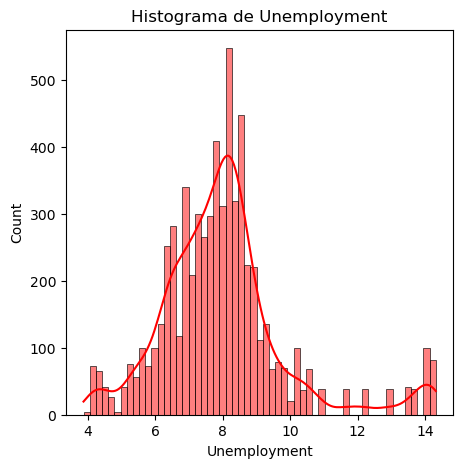

In [89]:
histograma(df,'Unemployment')

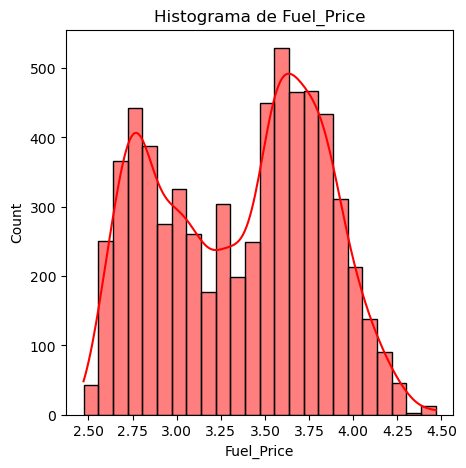

In [90]:
histograma(df,'Fuel_Price')

__Analisis__: Como se puede ver en los graficos, el único que posee una distribución que gausseana es Unemployment.
Por esta razón duante la normalización se elige Normalizer(norm = 'l2', copy = True)

#### Eliminación de columnas

In [91]:
#Se eliminan las columnas Date, Holiday_Flag, Temperature y Store ya que se concidera
#que no tienen una relación real con el desempleo
df = df.drop(['Date'], axis = 1)
df = df.drop(['Holiday_Flag'], axis = 1)
df = df.drop(['Temperature'], axis = 1)
df = df.drop(['Store'], axis = 1)

#### Escalado de datos

__Nota:__ Se mostraran diferentes normalizaciones para ver su impacto en el modelo.
Tambien se normalizaran las variables independientes y dependientes asi como tambien solo las independientes.

In [92]:
#Primera normalización Normalizer(norm = 'l2', copy = True)
escala = preprocessing.Normalizer(norm = 'l2', copy = True)

In [93]:
#Se crea otro datafreme para no modificar el original
df_norm = pd.DataFrame(df)

In [94]:
#df_norm[['Weekly_Sales','Fuel_Price','CPI']] = escala.fit_transform(df[['Weekly_Sales','Fuel_Price','CPI']])
df_norm = escala.fit_transform(df)
df_norm = pd.DataFrame(df_norm, columns=df.columns)

In [95]:
# Muesta del DataFrame normalizado
df_norm

,Weekly_Sales,Fuel_Price,CPI,Unemployment
0,1.0,0.000002,0.000128,0.000005
1,1.0,0.000002,0.000129,0.000005
2,1.0,0.000002,0.000131,0.000005
3,1.0,0.000002,0.000150,0.000006
4,1.0,0.000002,0.000136,0.000005
...,...,...,...,...
6430,1.0,0.000006,0.000269,0.000012
6431,1.0,0.000005,0.000262,0.000012
6432,1.0,0.000005,0.000262,0.000012
6433,1.0,0.000006,0.000268,0.000012


In [96]:
#Se separan la variable dependiente de las independientes
X = df_norm[['CPI',"Fuel_Price","Weekly_Sales"]].values
y = df_norm['Unemployment'].values

In [97]:
#media de Unemployment del dato 
y.mean()

1.0791370065040862e-05

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [99]:
#Muesta de como se ven los datos
X_train

array([[1.40878296e-04, 3.27565484e-06, 9.99999990e-01],
       [1.33091521e-04, 1.90116699e-06, 9.99999991e-01],
       [9.35910761e-05, 1.99207012e-06, 9.99999996e-01],
       ...,
       [1.33676329e-04, 3.87146589e-06, 9.99999991e-01],
       [1.00703591e-04, 2.15194281e-06, 9.99999995e-01],
       [1.07658578e-04, 1.56199099e-06, 9.99999994e-01]])

In [100]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train)

LinearRegression()

In [101]:
df_norm = df_norm.drop(['Unemployment'], axis=1)
df_norm = df_norm.T
df_norm = df_norm.index

In [102]:
#Coeficientes elegidos por el modelo
coeff_df = pd.DataFrame(regressor.coef_, df_norm, columns=['Coefficient']) 
coeff_df

,Coefficient
Weekly_Sales,0.020088
Fuel_Price,2.133704
CPI,55.721298


In [103]:
#Prediccion de los datos
y_pred = regressor.predict(X_test)

In [104]:
df_comparativo = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df_comparativo.head(25)
df1.head()
df1.sort_values('Actual')

,Actual,Predicted
15,0.000004,0.000006
16,0.000005,0.000005
7,0.000005,0.000006
24,0.000005,0.000006
8,0.000005,0.000007
17,0.000005,0.000006
1,0.000006,0.000008
13,0.000007,0.000006
5,0.000009,0.000008
19,0.000010,0.000010


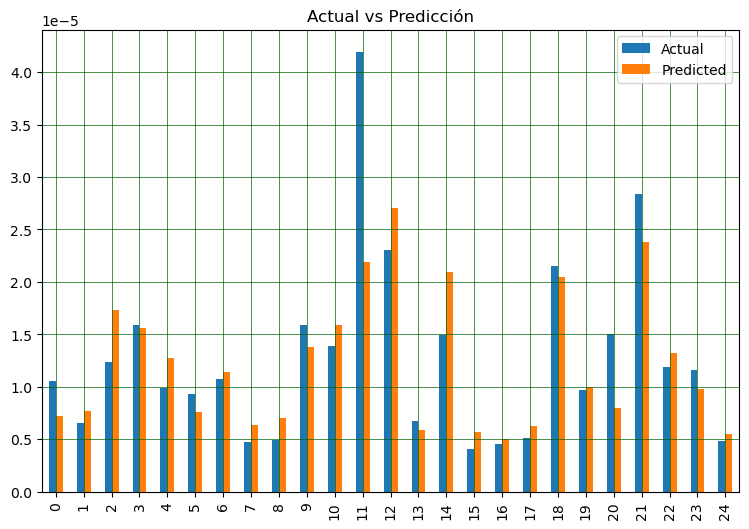

In [105]:
df1.plot(kind='bar',figsize=(9,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='darkgreen')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Actual vs Predicción")
plt.show()

In [106]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.2751077081568295e-06
Mean Squared Error: 1.2111477498732257e-11
Root Mean Squared Error: 3.4801548095928515e-06


__Primer Resultado:__ El error cuadratico medio es de 3.4801e-06 que es un 32.25% superior respecto a la media normalizada de y 1.079e-05

In [107]:
#Segunda normalización Normalizer(norm = 'l2', copy = True)
#Solo se normalizará la variable independiente.
escala2 = preprocessing.Normalizer(norm = 'l2', copy = True)
df_norm2 = pd.DataFrame(df)
df_norm2[['Weekly_Sales','Fuel_Price','CPI']] = escala.fit_transform(df[['Weekly_Sales','Fuel_Price','CPI']])
df_norm2 = pd.DataFrame(df_norm2, columns=df.columns)

In [108]:
X = df_norm2[['CPI',"Fuel_Price","Weekly_Sales"]].values
y = df_norm2['Unemployment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression() 
regressor.fit(X_train, y_train)

LinearRegression()

In [109]:
df_norm2 = df_norm2.drop(['Unemployment'], axis=1)
df_norm2 = df_norm2.T
df_norm2 = df_norm2.index

In [110]:
#Coeficientes elegidos por el modelo
coeff_df = pd.DataFrame(regressor.coef_, df_norm2, columns=['Coefficient']) 
coeff_df

,Coefficient
Weekly_Sales,-9.421179e+02
Fuel_Price,2.587683e+05
CPI,1.300640e+07


In [111]:
y_pred = regressor.predict(X_test)

In [112]:
df_comparativo2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df_comparativo2.head(25)
df1.head()
df1.sort_values('Actual')

,Actual,Predicted
24,5.892,7.997344
12,6.078,8.589850
8,6.123,7.875176
2,6.232,8.058824
14,6.339,8.083302
7,6.565,7.877250
15,6.943,8.140972
6,6.986,7.843169
17,7.057,7.873785
4,7.082,8.010471


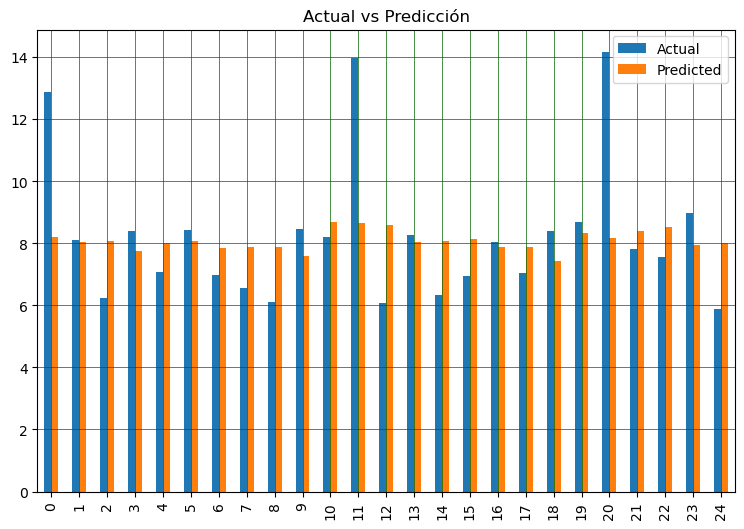

In [113]:
df1.plot(kind='bar',figsize=(9,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='darkgreen')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Actual vs Predicción")
plt.show()

In [114]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.265625130519572
Mean Squared Error: 3.2787129667148966
Root Mean Squared Error: 1.8107216701400843


__Segundo Resultado:__ El error cuadratico medio es de 1.8107 que es un 22.65% superior respecto a la media normalizada de y 7.9991

__Nota:__ Se utilizo tambien el StandardScaler() dando un resultado identico al __Segundo Resultado__

__Tercer Resultado:__

Mean Absolute Error: 1.2656251304761537

Mean Squared Error: 3.278712966628596

Root Mean Squared Error: 1.8107216701162538


No se presenta implementación por falta de valor al trabajo.

### Conclusion:

Se analizó el dataset waltmart.csv al cual se le aplicaron varias normalizaciones para ver cual se adaptaba mejor a los datos.

__Primer Resultado:__ El error cuadratico medio es de 3.4801e-06 que es un 32.25% superior respecto a la media normalizada de y 1.079e-05

__Segundo Resultado:__ El error cuadratico medio es de 1.8107 que es un 22.65% superior respecto a la media normalizada de y 7.9991

__Tercer Resultado:__ Identico al segundo.

Se puede llegar a la conclusión de que el segundo algoritmo implementado es más preciso que los otros dos.
A pesar de esto aún esta lejos de ser perfecto pese a que puede hacer algunas predicciones buenas.

Los factores a los que se le pueden haber atribuir la inexactitud son:

1. Baja correlación entre los valores
2. La suposición de que estos datos tienen una relación lineal puede no ser cierta.
3. Valores fuera de rango. Se puede observar que hay valores que se escapan por mucho de la media generando mucha distorsión